Is Transfer Learning better than building something new?

Imports

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 


2025-02-28 16:23:07.728224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 16:23:08.100283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 16:23:08.242770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 16:23:09.463859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 16:23:15.949270: W tensorflow/compiler/tf2

Check GPU


In [2]:
# If you have a GPU available, use it:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load in Data

In [ ]:
train_dir = "path/to/train/images"
val_dir = "path/to/val/images"

# refitting the image size to 32x32 instead of 256x256
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True 
)

# Scaling down from 255 to 0-1 values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 140002 files belonging to 2 classes.


2025-02-28 16:23:54.648490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4764 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1
2025-02-28 16:23:54.649060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7500 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:06:00.0, compute capability: 6.1
2025-02-28 16:23:54.649530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 7500 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1
2025-02-28 16:23:54.650007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 921 MB memory:  -> device: 3, name: NVIDIA GeForce GTX 1080, pci

Found 39428 files belonging to 2 classes.


Training

In [4]:
model = tf.keras.applications.VGG19(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
for layer in model.layers[:20]:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(model.input, predictions)

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

with tf.device('/gpu:0'):
    model_final.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics=['accuracy'])
    
    history = model_final.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callbacks)


In [7]:
model_final.save("../models/vgg_19_net.keras")

In [9]:
base_model = tf.keras.applications.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

efficient_model = Model(base_model.input, predictions)

In [10]:
tf.keras.backend.clear_session()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

with tf.device('/gpu:0'):
    efficient_model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics=['accuracy'])
    
    history_efficient = efficient_model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callbacks)

efficient_model.save("../models/efficient_net.keras")

Epoch 1/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 611s 125ms/step - accuracy: 0.5009 - loss: 1.1905 - val_accuracy: 0.5019 - val_loss: 0.6932
Epoch 2/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - accuracy: 0.4983 - loss: 0.6988 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 3/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 494s 113ms/step - accuracy: 0.4988 - loss: 0.6955 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 4/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 488s 111ms/step - accuracy: 0.4998 - loss: 0.6933 - val_accuracy: 0.4981 - val_loss: 0.6931
Epoch 5/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 490s 112ms/step - accuracy: 0.4987 - loss: 0.6954 - val_accuracy: 0.4981 - val_loss: 0.6931


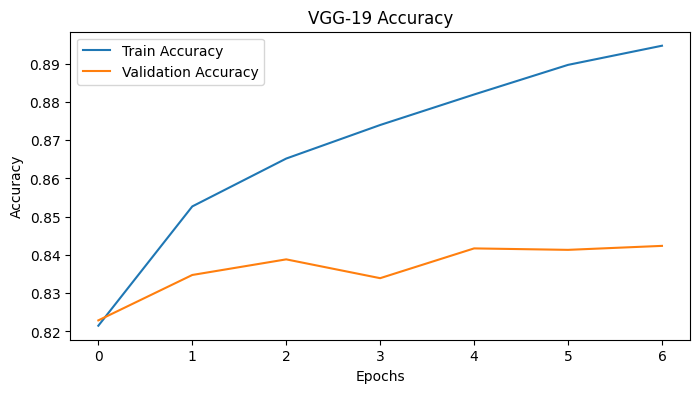

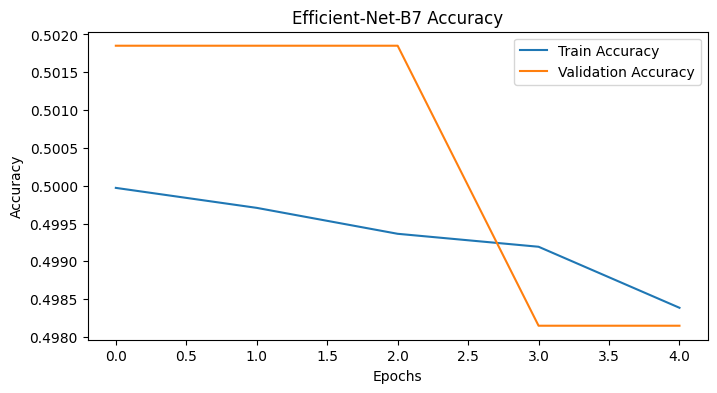

In [11]:
import matplotlib.pyplot as plt

def plot_training(history, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Plot results
plot_training(history, "VGG-19")
plot_training(history_efficient, "Efficient-Net-B7")
